# Head 1st / Head 2nd / Work 1st / Work 2nd

In [1]:
import pyreadstat
import os
import gc
import numpy as np
import copy
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

.sav ===> import pyreadstat, pyreadstat.read_sav(file_path)

.sas7bdat  ====> pandas, pd.read_sas(file_path)

.dta  ===> pd.read_stata(file_path)

In [2]:
def call_df():
    path = 'C:/Users/hml76/Desktop/UMN/연구/HRD_Minjeong/Data/HCCPII_20230828/'
    file_path = path+'2. SPSS/HCCP_2ndWave_Work_2nd.sav'

    dataframe, meta = pyreadstat.read_sav(file_path)
    columns_to_drop0 = ['W21ID2', 'W21ID3']
    dataframe = dataframe.drop(columns=columns_to_drop0)
    
    #y = df[y_name]
    #df.drop(columns=[y_name])
    gc.collect()
    return dataframe

In [3]:
def check_nan(input_dataframe):
    nan_values = input_dataframe.isna()
    nan_count_per_column = nan_values.sum()
    Nan_cols = []
    columns_with_nan = nan_count_per_column[nan_count_per_column > 0]  # Filter columns with NaN values
    print("Columns with NaN values and count of NaN values:")
    for column, count in columns_with_nan.items():
        print(f"Column '{column}' has {count} NaN value(s).")
        Nan_cols.append(column)    
        
    dataframe = input_dataframe.drop(columns=Nan_cols)
    return dataframe


def equal_distirubution(dataframe, y_lst, class_idx):
    class_counts = dataframe[y_lst[class_idx]].value_counts()
    print(class_counts)
    max_samples, min_samples = class_counts.max(), class_counts.min()
    
    balanced_df = pd.DataFrame()  # Initialize an empty DataFrame to store the balanced data
    
    for class_label, count in class_counts.items():
        if count == min_samples:      # If the class count is equal to the maximum number of samples, keep all samples
            balanced_df = pd.concat([balanced_df, dataframe[dataframe[y_lst[class_idx]] == class_label]])
        else:
            sampled_df = dataframe[dataframe[y_lst[class_idx]] == class_label].sample(min_samples, replace=True)  # Randomly sample the same number of samples from the class
            balanced_df = pd.concat([balanced_df, sampled_df])
    
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the rows 
    y_balanced = balanced_df[y_lst[class_idx]]
    print(y_balanced.value_counts())
    X_balanced = balanced_df.drop(columns=y_lst)
    
    return X_balanced, y_balanced

# ML models

In [4]:
def XGBoost(X_balanced, y_balanced):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    model = XGBClassifier(subsample=0.8, reg_lambda=0, reg_alpha=0.5, n_estimators=200,
                    min_child_weight=3, max_depth=7, learning_rate=0.1, gamma=0.1,
                    colsample_bytree=0.6)
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("\tAccuracy ========> ", accuracy)
    
    #plot_importance(model, max_num_features=10)
    #plt.show()
    
    return model, X_train, X_test, y_test

In [5]:
def LightGBM(X_balanced, y_balanced, num_boost_round = 300):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    model = LGBMClassifier(subsample=0.8, n_estimators=200, min_child_weight=1,
                     max_depth=5, learning_rate=0.1, colsample_bytree=0.8)

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("\tAccuracy ========> ", accuracy)
    
    #plot_importance(model, max_num_features=10)
    #plt.show()
    
    return model, X_train, X_test, y_test

In [6]:
def CatBoost(X_balanced, y_balanced, num_boost_round = 300):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    model = CatBoostClassifier(subsample=0.8, n_estimators=300, max_depth=5, learning_rate=0.3)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("\tAccuracy ========> ", accuracy)
    
    #plot_importance(model, max_num_features=10)
    #plt.show()
    
    return model, X_train, X_test, y_test

In [7]:
def RF(X_balanced, y_balanced):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    #model = RandomForestClassifier(n_estimators=num_boost_round)
    model = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_depth=20, random_state=42)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("\tAccuracy ========> ", accuracy)
    
    #plot_importance(model, max_num_features=10)
    #plt.show()
    
    return model, X_train, X_test, y_test

# Feature importance

In [8]:
def feature_imp1(input_model, X_train_, top_k):
    feature_importance = input_model.feature_importances_
    top_indices = np.argsort(feature_importance)[::-1][:top_k]
    top_indices = X.columns[top_indices]
    
    return top_indices

In [9]:
def feature_imp2(input_model, max_num_features):
    plot_importance(input_model, max_num_features)
    plt.show()

In [10]:
def class_one_to_five_TO_one_to_two(dataframe, y_lst, class_idx):
    dataframe_1 = dataframe[dataframe[y_lst[class_idx]] != 3]
    dataframe_1[y_lst[class_idx]] = dataframe_1[y_lst[class_idx]].map({1: 1, 2: 1, 4: 2, 5: 2})
    #dataframe_1 = dataframe_1.drop(columns=y_lst[class_idx])
    #print(dataframe_1[y_lst[class_idx]])
    return dataframe_1

In [11]:
def erase_col_for_importance(dataframe, erase_col_lst):
    dataframe = dataframe.drop(columns=erase_col_lst)
    
    return dataframe

In [12]:
scaler = MinMaxScaler()
df = call_df()
df = check_nan(df)
DF = copy.deepcopy(df)

Columns with NaN values and count of NaN values:
Column 'W21Q11A2' has 2349 NaN value(s).
Column 'W21Q11B2' has 3583 NaN value(s).
Column 'W21Q15A2' has 4487 NaN value(s).
Column 'W21Q15B2' has 3978 NaN value(s).
Column 'W21Q15C2' has 3584 NaN value(s).
Column 'W21Q15D2' has 5690 NaN value(s).
Column 'W21Q15E2' has 6613 NaN value(s).
Column 'W21Q16A2' has 6895 NaN value(s).
Column 'W21Q16B2' has 9294 NaN value(s).
Column 'W21Q16C2' has 9409 NaN value(s).
Column 'W21Q16D2' has 9456 NaN value(s).
Column 'W21Q191' has 6105 NaN value(s).
Column 'W21Q192' has 6105 NaN value(s).
Column 'W21Q31A' has 1259 NaN value(s).
Column 'W21Q31B' has 8119 NaN value(s).
Column 'W21DQ041' has 1536 NaN value(s).


In [13]:
from sklearn.model_selection import RandomizedSearchCV

def RF_grid_search(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300], #400
        'max_depth': [10, 20, 30], #None
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    clf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Best Parameters:", best_params)
    

def LGBM_grid_search(X_train, y_train):
    param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    }
    
    clf = LGBMClassifier()
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Best Parameters:", best_params)
    
    

def Catboost_grid_search(X_train, y_train):
    param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    }
    
    clf = CatBoostClassifier(verbose=False)
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Best Parameters:", best_params)
    

def XGBoost_grid_search(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [0, 0.1, 0.5, 1.0],
    }
    

    clf = XGBClassifier()
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Best Parameters:", best_params)

# Image - distribution sample

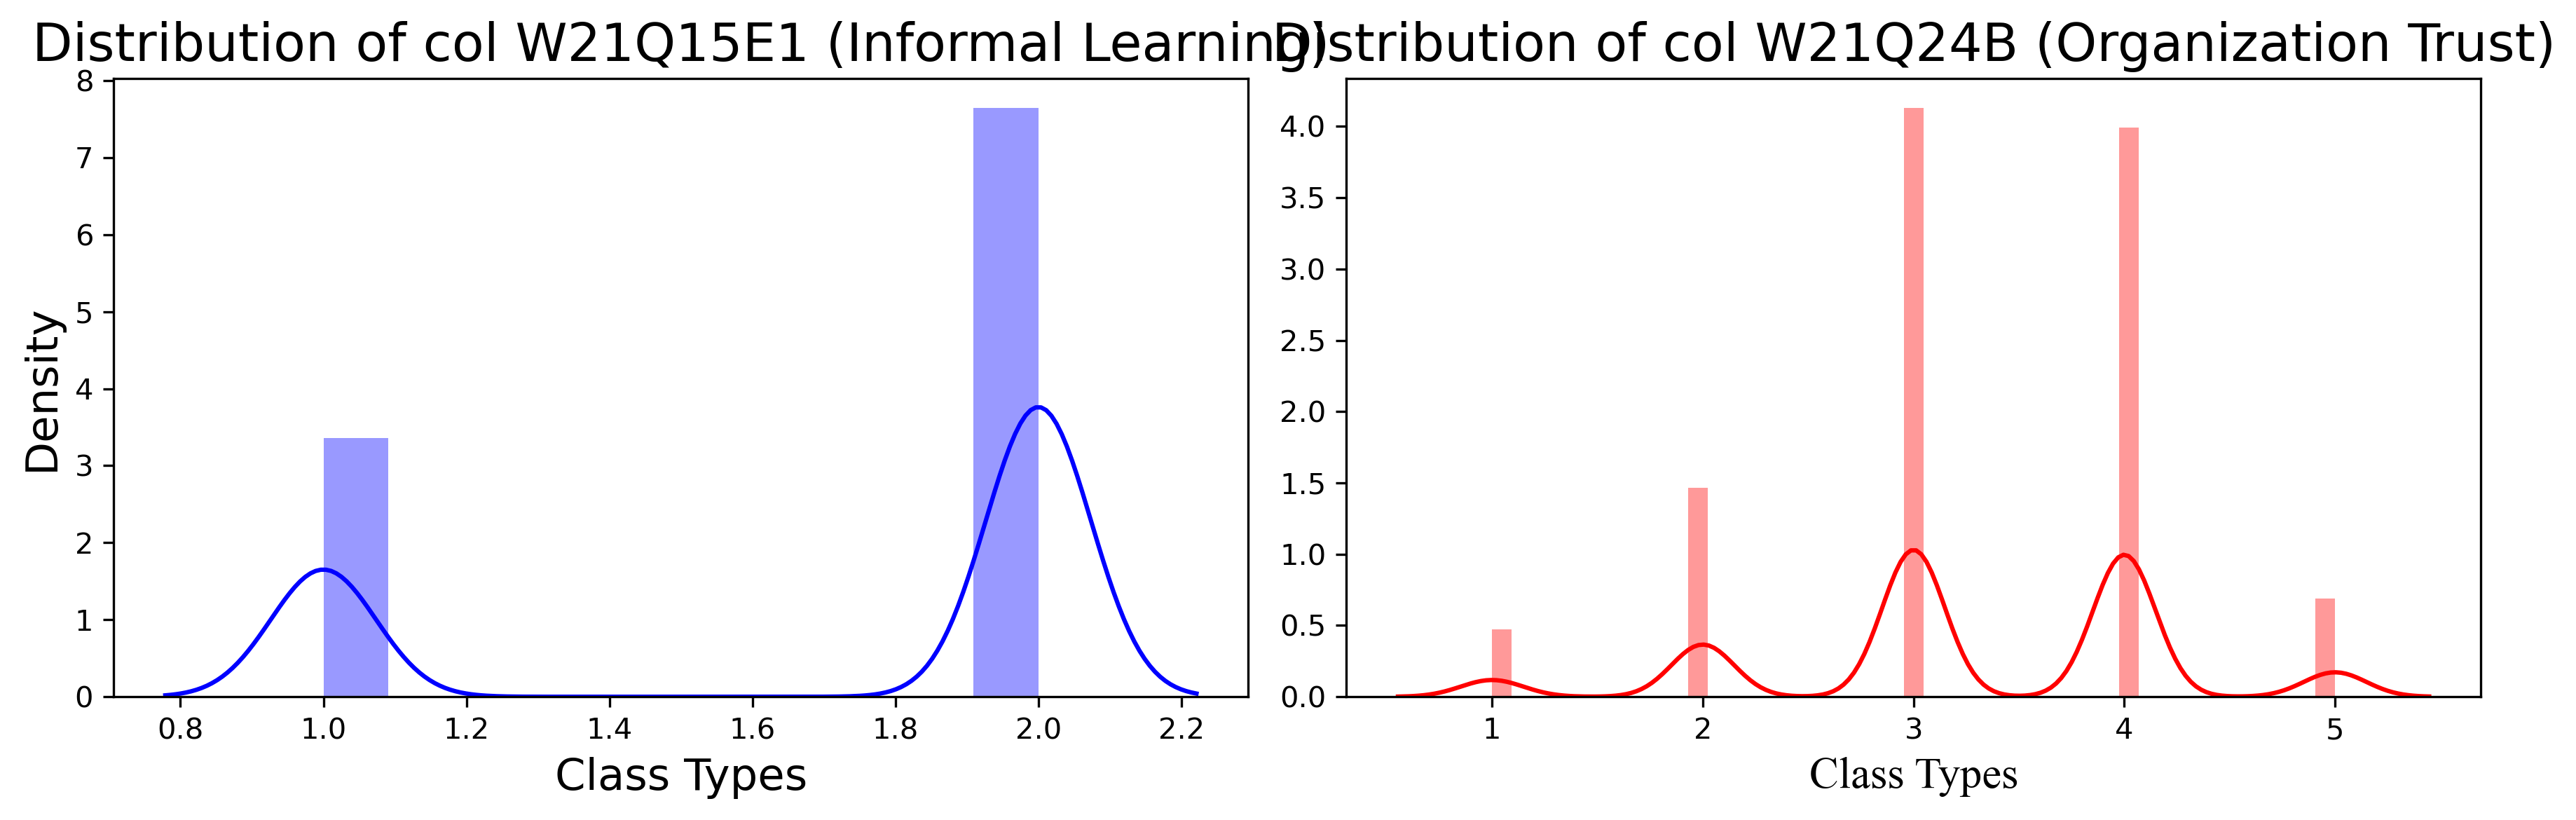

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)

plt.rcParams['font.family'] = 'Times New Roman'
font = "Times New Roman"

sns.distplot(df['W21Q15E1'], ax=axes[0], color='blue')
axes[0].set_title("Distribution of col W21Q15E1 (Informal Learning)", fontsize=18)
axes[0].set_xlabel('Class Types', fontsize=15)
axes[0].set_ylabel("Density", fontsize=15)

sns.distplot(df['W21Q24B'], ax=axes[1], color='red')
axes[1].set_title("Distribution of col W21Q24B (Organization Trust)", fontsize=18)
axes[1].set_xlabel('Class Types', fontsize=15, fontname=font)
axes[1].set_ylabel("")


plt.tight_layout()
plt.show()

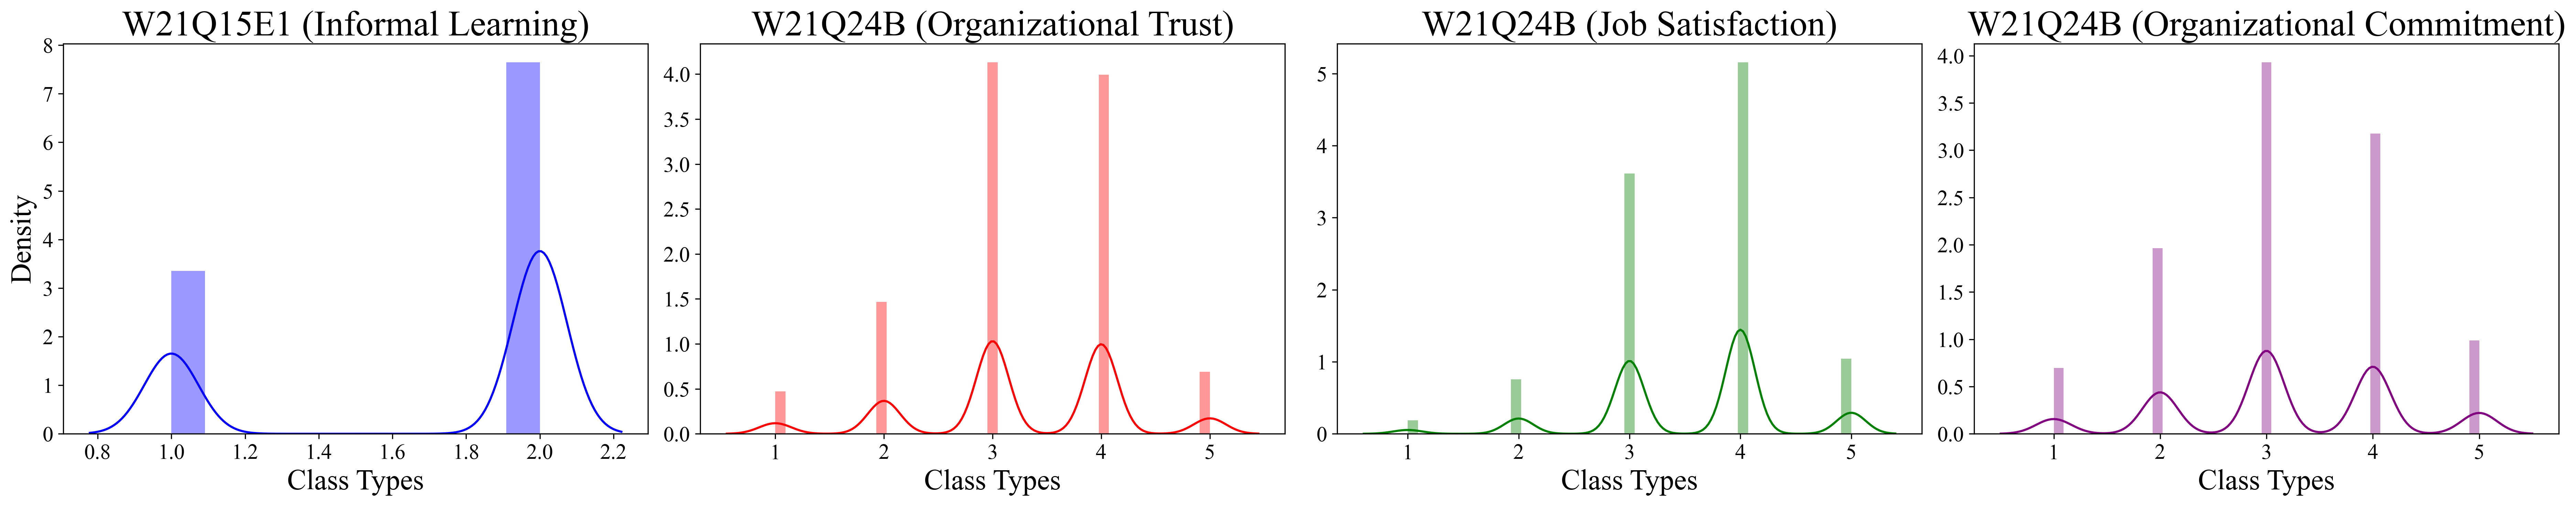

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(25, 5), dpi=300)

plt.rcParams['font.family'] = 'Times New Roman'
font = "Times New Roman"

axis_font, title_font = 20, 25

sns.distplot(df['W21Q15E1'], ax=axes[0], color='blue')
axes[0].set_title("W21Q15E1 (Informal Learning)", fontsize=title_font)
axes[0].set_xlabel('Class Types', fontsize=axis_font)
axes[0].set_ylabel("Density", fontsize=axis_font)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)

sns.distplot(df['W21Q24B'], ax=axes[1], color='red')
axes[1].set_title("W21Q24B (Organizational Trust)", fontsize=title_font)
axes[1].set_xlabel('Class Types', fontsize=axis_font, fontname=font)
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

sns.distplot(df['W21Q26A'], ax=axes[2], color='green')
axes[2].set_title("W21Q24B (Job Satisfaction)", fontsize=title_font)
axes[2].set_xlabel('Class Types', fontsize=axis_font, fontname=font)
axes[2].set_ylabel("")
axes[2].tick_params(axis='x', labelsize=15)
axes[2].tick_params(axis='y', labelsize=15)

sns.distplot(df['W21Q27A'], ax=axes[3], color='purple')
axes[3].set_title("W21Q24B (Organizational Commitment)", fontsize=title_font)
axes[3].set_xlabel('Class Types', fontsize=axis_font, fontname=font)
axes[3].set_ylabel("")
axes[3].tick_params(axis='x', labelsize=15)
axes[3].tick_params(axis='y', labelsize=15)


plt.tight_layout()
plt.show()

In [16]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def XGBoost_learning_curve(X_balanced, y_balanced, title):
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

    model = XGBClassifier(subsample=0.8, reg_lambda=0, reg_alpha=0.5, n_estimators=200,
                          min_child_weight=3, max_depth=7, learning_rate=0.1, gamma=0.1,
                          colsample_bytree=0.6)

    eval_set = [(X_train, y_train), (X_test, y_test)]  # Use both training and test sets for evaluation
    eval_metric = ["error", "logloss"]  # Evaluation metrics to be monitored
    model.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=100, verbose=False)

    # Extracting the evaluation results
    eval_results = model.evals_result()

    # Plotting the learning curves
    num_epochs = len(eval_results['validation_0']['error'])  # Number of epochs
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(13, 3.5), dpi=150)
    plt.rcParams['font.family'] = 'Times New Roman'

    # Plot training and validation log loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, eval_results['validation_0']['logloss'], label='Train', marker='o', markersize=3)
    plt.plot(epochs, eval_results['validation_1']['logloss'], label='Test', marker='o', markersize=3)
    plt.xlabel('Number of Epochs', fontsize=13)
    plt.ylabel('Log Loss', fontsize=13)
    plt.title('{}'.format(title), fontsize=15)
    plt.legend(fontsize=12)
    
    #plt.tight_layout()
    plt.grid(True, linestyle='dotted')
    plt.show()

    return model, X_train, X_test, y_test

In [21]:
from sklearn.inspection import permutation_importance
def permutational_importance_(model, x_test_, y_test_, Xs):
    result = permutation_importance(model, x_test_, y_test_, n_repeats=10, random_state=42)

    feature_names = Xs.columns

    sorted_idx = result.importances_mean.argsort()

    #plt.figure(figsize=(10, 6))
    #plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
    #plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    #plt.xlabel('Permutation Importance')
    #plt.title('Permutation Importances')
    #plt.show()
    
    print(feature_names[sorted_idx][-10:])
    
    return feature_names[sorted_idx][-10:]

# 1. 비공식학습 참여여부

(1)동료에 의한 코칭 및 멘토링_비공식적 학습 방법 참여 여부

(2)상사에 의한 코칭 및 멘토링_비공식적 학습 방법 참여 여부

(3)직원들 개개인 간의 지식 및 노하우 공유_비공식적 학습 방법 참여 여부

(4)사내 플랫폼을 통한 지식 공유_비공식적 학습 방법 참여 여부

(5)직무순환을 통한 학습_비공식적 학습 방법 참여 여부

# Loss graph

In [ ]:
#binary class
Y = ['W21Q15A1', 'W21Q15B1', 'W21Q15C1', 'W21Q15D1', 'W21Q15E1'] #1. 비공식학습 참여여부  => 성능 나쁨; 거의 65% 
#Y2 = ['W21Q15A2', 'W21Q15B2', 'W21Q15C2', 'W21Q15D2', 'W21Q15E2'] # 비공식학습 학습성과 

for i in range(len(Y)):
#for i in range(1):
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X, y = equal_distirubution(df, Y, i)
    y=y-1
    
    #X = erase_col_for_importance(X, list2)
    model, x_tr, _, _ = XGBoost_learning_curve(X, y)

# Learnings

In [ ]:
#binary class
Y = ['W21Q15A1', 'W21Q15B1', 'W21Q15C1', 'W21Q15D1', 'W21Q15E1'] #1. 비공식학습 참여여부  => 성능 나쁨; 거의 65% 
#Y2 = ['W21Q15A2', 'W21Q15B2', 'W21Q15C2', 'W21Q15D2', 'W21Q15E2'] # 비공식학습 학습성과 

for i in range(len(Y)):
#for i in range(1):
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    #X, y = equal_distirubution(df, Y, i)
    y=y-1
    
    #X = erase_col_for_importance(X, list2)
    model, x_tr, _, _ = XGBoost(X, y)
    model, x_tr, _, _ = LightGBM(X, y)
    model, x_tr, _, _ = CatBoost(X, y)
    model, x_tr, _, _ = RF(X, y)
    feature_imp1(model, x_tr, top_k=10)

# 3. 자기주도학습 참여여부

(1)학원 수강료 지원 제도_2019년 자기주도적 학습 지원 제도 참여 여부

(2)국내 대학 등록금 지원 제도_2019년 자기주도적 학습 지원 제도 참여 여부

(3)국내 대학원 등록금 지원 제도_2019년 자기주도적 학습 지원 제도 참여 여부

(4)해외 대학원 학위과정 지원 제도_2019년 자기주도적 학습 지원 제도 참여 여부

In [ ]:
#Binary Class
Y = ['W21Q16A1', 'W21Q16B1', 'W21Q16C1', 'W21Q16D1']  #2. 자기주도학습 참여여부 => 성능 괜찮음: 76 ~ 92%
#Y2 = ['W21Q16A2', 'W21Q16B2', 'W21Q16C2', 'W21Q16D2']  #자기주도학습 학습성과

In [ ]:
for i in range(len(Y)):
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X, y = equal_distirubution(df, Y, i)
    
    y=y-1
    model, x_tr, _, _ = XGBoost(X, y, num_boost_round = 300)
    feature_imp1(model, x_tr, top_k=10)

# 5. 조직신뢰 

(1)직원들에게 회사 사정을 소상하게 알려준다

(2)상급자에게 의견을 자유롭게 낼 수 있다

(3)부서간의 커뮤니케이션이 잘 되는 편이다

(4)동료들 간에 서로 신뢰한다

(5)평가 및 보상이 공정하게 이루어진다

(6)경영진은 모든 면에서 믿고 따라갈 만하다

2개로 줄임: Class (1, 2) ====> 1 & (4, 5) ====> 2 & (3) ====> 삭제 

2    3563
1    2386
Name: W21Q24A, dtype: int64
2    2386
1    2386
Name: W21Q24A, dtype: int64


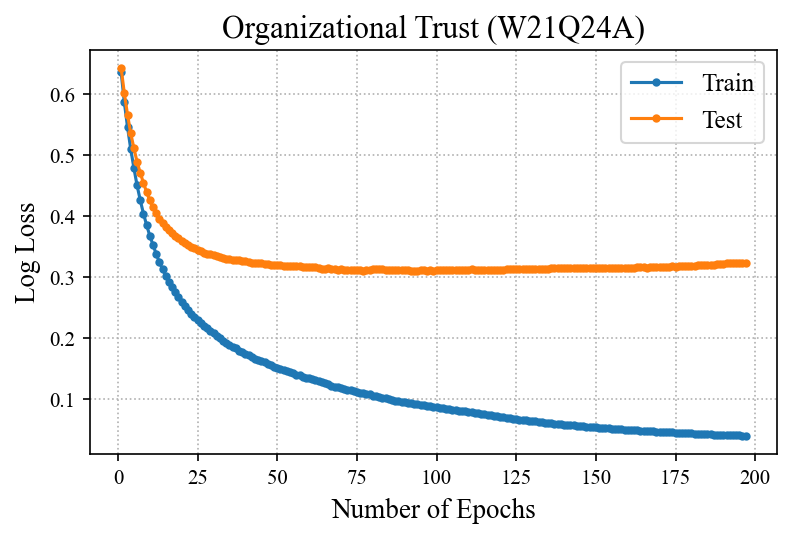

In [17]:
Y = ['W21Q24A', 'W21Q24B', 'W21Q24C', 'W21Q24D', 'W21Q24E', 'W21Q24F']

for i in range(1):  
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    X, y = equal_distirubution(X, Y, i)
    y=y-1
    model, x_tr, _, _ = XGBoost_learning_curve(X, y, 'Organizational Trust (W21Q24A)')

In [18]:
#Multi Class - 5
Y = ['W21Q24A', 'W21Q24B', 'W21Q24C', 'W21Q24D', 'W21Q24E', 'W21Q24F']

for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, _, _ = XGBoost(X, y)
    model, x_tr, _, _ = LightGBM(X, y)
    model, x_tr, _, _ = CatBoost(X, y)
    model, x_tr, _, _ = RF(X, y)
    #RF_grid_search(X, y)
    #Catboost_grid_search(X,y)
    #model, x_tr, _, _ = XGBoost(X, y, num_boost_round = 300)
    #feature_imp1(model, x_tr, top_k=10)


 W21Q24A 

2    3563
1    2386
Name: W21Q24A, dtype: int64
2    2386
1    2386
Name: W21Q24A, dtype: int64
	Accuracy ========>  0.8952879581151832
	Accuracy ========>  0.8879581151832461
	Accuracy ========>  0.8680628272251308
	Accuracy ========>  0.8869109947643979

 W21Q24B 

2    4144
1    1716
Name: W21Q24B, dtype: int64
2    1716
1    1716
Name: W21Q24B, dtype: int64
	Accuracy ========>  0.8777292576419214
	Accuracy ========>  0.8748180494905385
	Accuracy ========>  0.86608442503639
	Accuracy ========>  0.883551673944687

 W21Q24C 

2    3855
1    1744
Name: W21Q24C, dtype: int64
2    1744
1    1744
Name: W21Q24C, dtype: int64
	Accuracy ========>  0.8767908309455588
	Accuracy ========>  0.8911174785100286
	Accuracy ========>  0.8753581661891118
	Accuracy ========>  0.8882521489971347

 W21Q24D 

2    4755
1    1008
Name: W21Q24D, dtype: int64
1    1008
2    1008
Name: W21Q24D, dtype: int64
	Accuracy ========>  0.905940594059406
	Accuracy ========>  0.8985148514851485
	Accuracy ==


 W21Q24A 

2    3563
1    2386
Name: W21Q24A, dtype: int64
2    2386
1    2386
Name: W21Q24A, dtype: int64
	Accuracy ========>  0.8879581151832461
Index(['W21Q22C', 'W21Q062B', 'W21Q27G', 'W21Q04', 'W21Q25A', 'W21Q23B',
       'W21ID1', 'W21Q082A', 'W21Q23C', 'W21Q25B'],
      dtype='object')


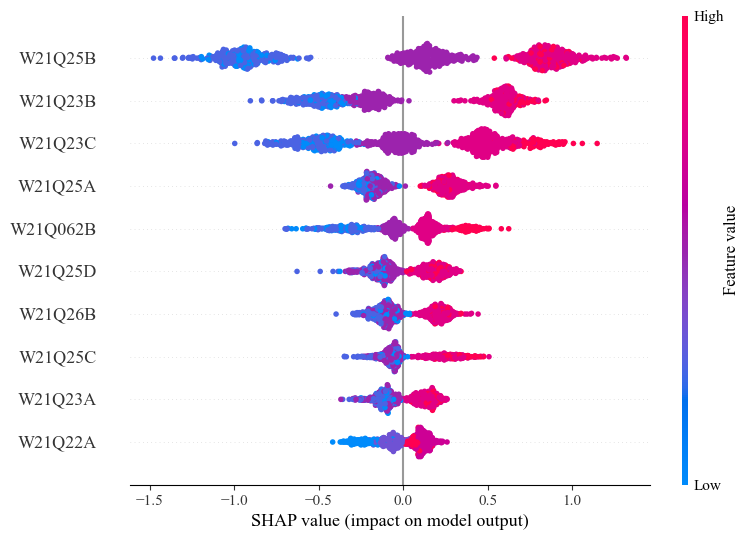


 W21Q24B 

2    4144
1    1716
Name: W21Q24B, dtype: int64
2    1716
1    1716
Name: W21Q24B, dtype: int64
	Accuracy ========>  0.87627365356623
Index(['W21Q22A', 'W21Q15C1', 'W21Q23B', 'W21Q01A', 'W21ID1', 'W21Q25B',
       'W21Q25C', 'W21Q22C', 'W21Q25D', 'W21Q25I'],
      dtype='object')


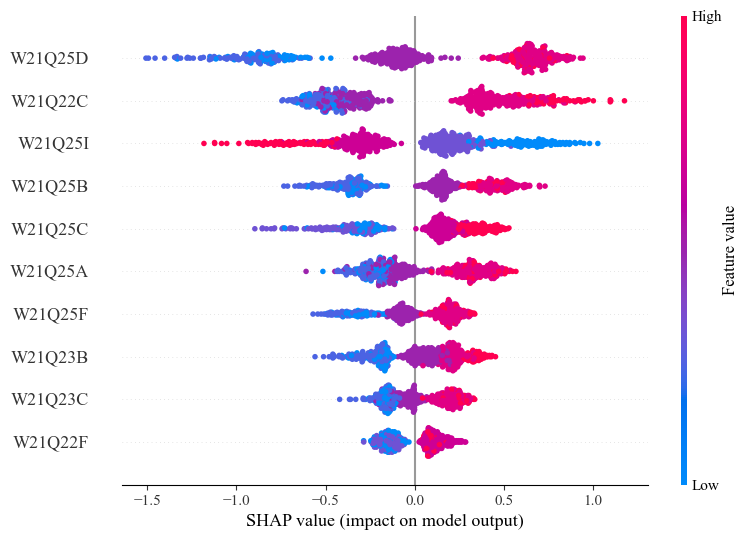


 W21Q24C 

2    3855
1    1744
Name: W21Q24C, dtype: int64
2    1744
1    1744
Name: W21Q24C, dtype: int64
	Accuracy ========>  0.8796561604584527
Index(['W21Q02A', 'W21Q09B', 'W21Q01A', 'W21Q27F', 'W21Q23B', 'W21Q26C',
       'W21Q22D', 'W21Q27E', 'W21ID1', 'W21Q25D'],
      dtype='object')


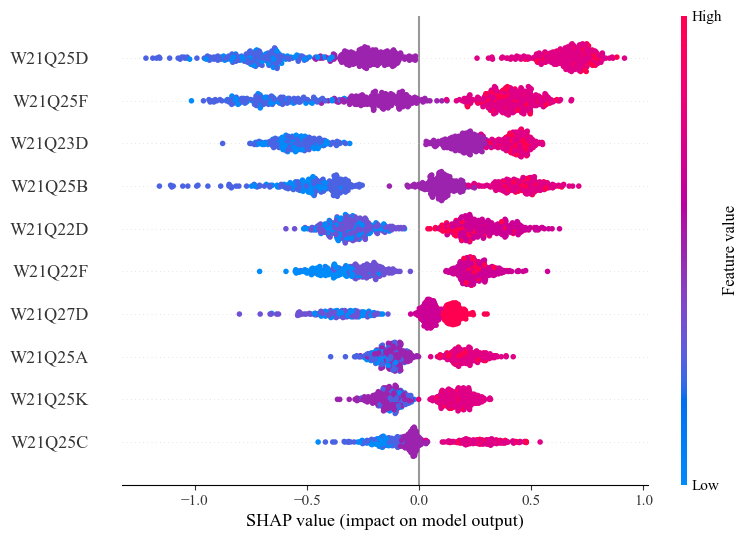


 W21Q24D 

2    4755
1    1008
Name: W21Q24D, dtype: int64
1    1008
2    1008
Name: W21Q24D, dtype: int64
	Accuracy ========>  0.905940594059406
Index(['W21Q10C', 'W21Q25E', 'W21Q03A', 'W21Q01A', 'W21Q22F', 'W21Q27F',
       'W21Q25F', 'W21Q22D', 'W21Q25D', 'W21Q26C'],
      dtype='object')


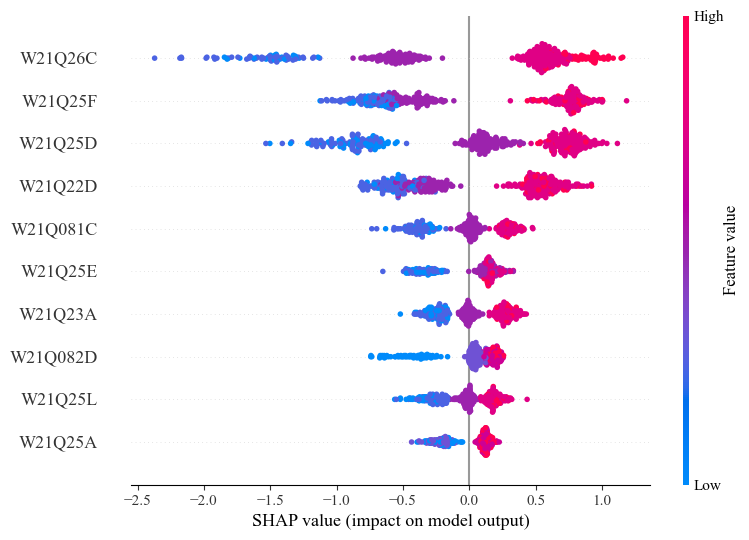


 W21Q24E 

2    3213
1    2301
Name: W21Q24E, dtype: int64
1    2301
2    2301
Name: W21Q24E, dtype: int64
	Accuracy ========>  0.9315960912052117
Index(['W21Q05B', 'W21Q25A', 'W21Q23B', 'W21Q23A', 'W21Q26B', 'W21Q27E',
       'W21Q25D', 'W21Q23D', 'W21Q25L', 'W21Q25B'],
      dtype='object')


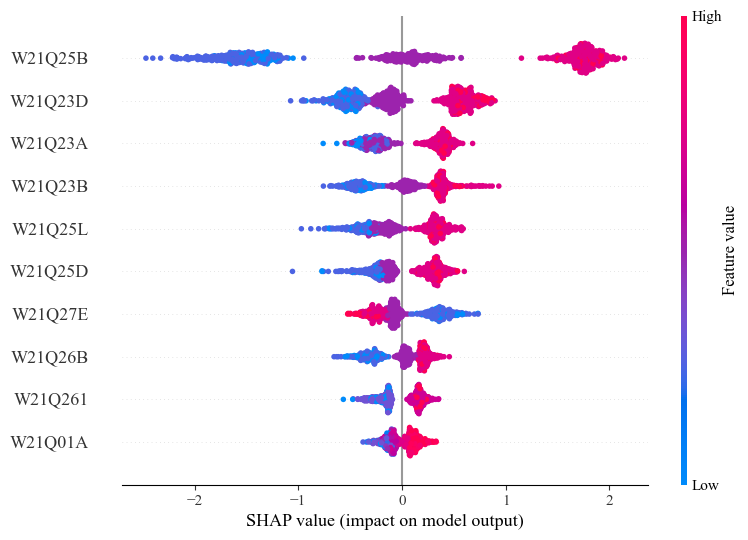


 W21Q24F 

2    3813
1    1757
Name: W21Q24F, dtype: int64
1    1757
2    1757
Name: W21Q24F, dtype: int64
	Accuracy ========>  0.9402560455192034
Index(['W21Q14B', 'W21Q062C', 'W21Q25E', 'W21Q25F', 'W21Q17', 'W21DQ02B',
       'W21Q23B', 'W21Q081D', 'W21Q27D', 'W21Q25B'],
      dtype='object')


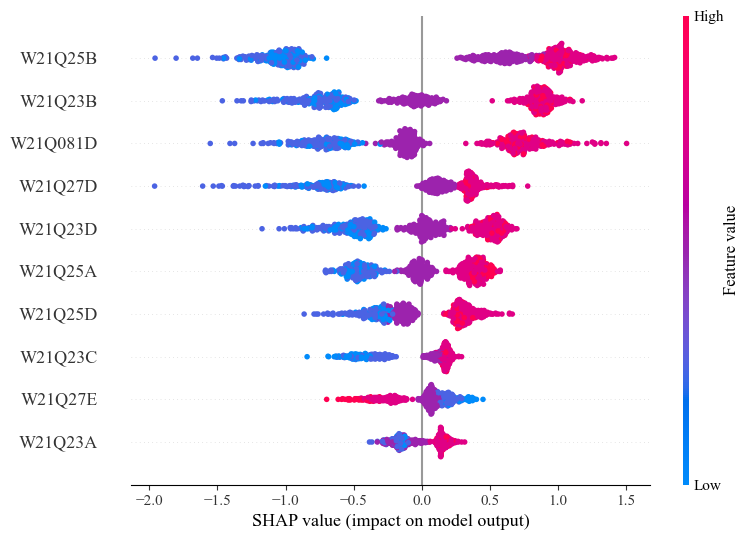

In [25]:
import shap

Y = ['W21Q24A', 'W21Q24B', 'W21Q24C', 'W21Q24D', 'W21Q24E', 'W21Q24F']

perum_imp = []
for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, x_tst, y_tst = XGBoost(X, y)
    
    PI = permutational_importance_(model, x_tst, y_tst, X)
    
    explainer = shap.TreeExplainer(model) 
    shap_values = explainer.shap_values(x_tst)

    shap.summary_plot(shap_values, x_tst, max_display=10, plot_type='dot')  #violin, dot, bar, compact_dot, layered_violin
    perum_imp.append(PI)

In [ ]:
#sv = explainer(X)
#shap.plots.waterfall(sv[0])

In [37]:
FI = [['W21Q25B', 'W21Q23B', 'W21Q23C', 'W21Q25A', 'W21Q062B', 'W21Q25D', 'W21Q26B', 'W21Q25C', 'W21Q23A', 'W21Q22A'], 
      ['W21Q25D', 'W21Q22C', 'W21Q25I', 'W21Q25B', 'W21Q25C', 'W21Q25A', 'W21Q25F', 'W21Q23B', 'W21Q23C', 'W21Q22F'],
      ['W21Q25D', 'W21Q25F', 'W21Q23D', 'W21Q25B', 'W21Q22D', 'W21Q22F', 'W21Q27D', 'W21Q25A', 'W21Q25K', 'W21Q25C'],
      ['W21Q26C', 'W21Q25F', 'W21Q25D', 'W21Q22D', 'W21Q081C', 'W21Q25E', 'W21Q23A', 'W21Q082D', 'W21Q25L', 'W21Q25A'],
      ['W21Q25B', 'W21Q23D', 'W21Q23A', 'W21Q23B', 'W21Q25L', 'W21Q25D', 'W21Q27E', 'W21Q26B', 'W21Q261', 'W21Q01A'],
      ['W21Q25B', 'W21Q23B', 'W21Q081D', 'W21Q27D', 'W21Q23D', 'W21Q25A', 'W21Q25D', 'W21Q23C', 'W21Q27E', 'W21Q23A'],
     ]

m2 = ['W21Q23A', 'W21Q25K', 'W21Q23B', 'W21Q23C', 'W21Q261', 'W21Q26C', 'W21Q23D', 'W21Q22D', 'W21Q25D', 'W21Q25B', 'W21Q25B', 
 'W21Q25D', 'W21Q23B', 'W21Q23D', 'W21Q25A', 'W21Q23C', 'W21Q26C', 'W21Q25L', 'W21Q26I', 'W21Q27D']

In [39]:
from collections import Counter

arr_1d = np.array(np.array(FI+perum_imp)).flatten()
arr_1d = arr_1d.tolist() + m2

element_counts = Counter(arr_1d)

top_5_elements = element_counts.most_common(5)

print("Top 5 elements with highest frequency:")
for element, frequency in top_5_elements:
    print("Element:", element, "Frequency:", frequency)

Top 5 elements with highest frequency:
Element: W21Q25D Frequency: 12
Element: W21Q25B Frequency: 11
Element: W21Q23B Frequency: 11
Element: W21Q25A Frequency: 8
Element: W21Q23C Frequency: 6


# 6. 직무만족 (Job Satisfaction)

(1)현재 하고 있는 일의 내용에 만족한다

(2)현재 받고 있는 임금에 만족한다

(3)현재 직장의 인간관계에 만족한다

하고 있는 일에 대한 전반적 만족도

In [ ]:
Y = ['W21Q26A', 'W21Q26B', 'W21Q26C', 'W21Q261']

for i in range(1):  
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    X, y = equal_distirubution(X, Y, i)
    y=y-1
    model, x_tr, _, _ = XGBoost_learning_curve(X, y, 'Job Satisfaction (W21Q26A)')

In [ ]:
Y = ['W21Q26A', 'W21Q26B', 'W21Q26C', 'W21Q261']

for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, _, _ = XGBoost(X, y)
    model, x_tr, _, _ = LightGBM(X, y)
    model, x_tr, _, _ = CatBoost(X, y)
    model, x_tr, _, _ = RF(X, y)
    #RF_grid_search(X, y)
    #Catboost_grid_search(X, y)
    #model, x_tr, _, _ = XGBoost(X, y, num_boost_round = 300)
    #feature_imp1(model, x_tr, top_k=10)


 W21Q26A 

2    5484
1     835
Name: W21Q26A, dtype: int64
1    835
2    835
Name: W21Q26A, dtype: int64
	Accuracy ========>  0.8413173652694611
Index(['W21Q25K', 'W21Q27D', 'W21Q25D', 'W21Q083A', 'W21Q062A', 'W21Q24B',
       'W21Q22C', 'W21Q27A', 'W21Q27B', 'W21Q27F'],
      dtype='object')


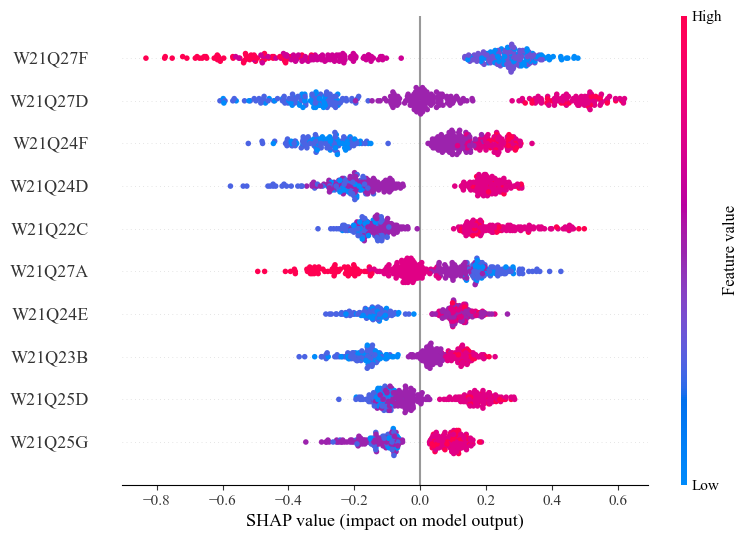


 W21Q26B 

2    3494
1    2359
Name: W21Q26B, dtype: int64
2    2359
1    2359
Name: W21Q26B, dtype: int64
	Accuracy ========>  0.875
Index(['W21Q17', 'W21Q061B', 'W21Q18A', 'W21Q09H', 'W21Q27B', 'W21Q25C',
       'W21Q27D', 'W21Q24E', 'W21DQ01', 'W21Q27A'],
      dtype='object')


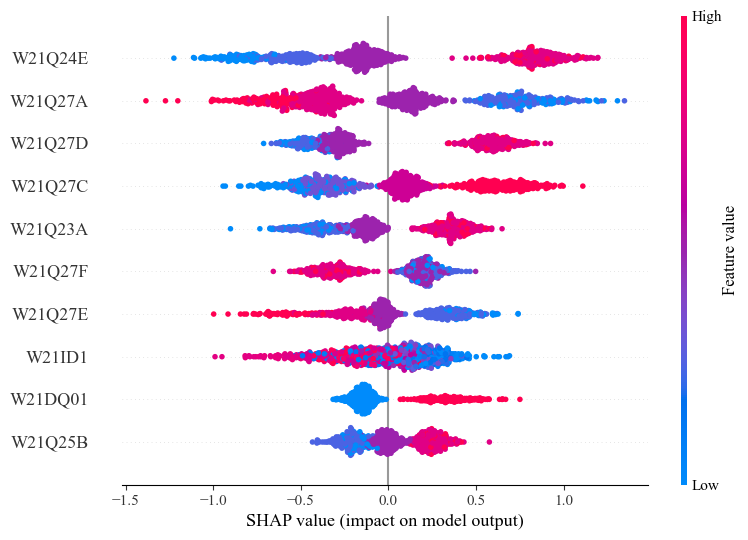


 W21Q26C 

2    6010
1     617
Name: W21Q26C, dtype: int64
1    617
2    617
Name: W21Q26C, dtype: int64
	Accuracy ========>  0.8259109311740891
Index(['W21Q22E', 'W21Q27E', 'W21Q23A', 'W21Q22B', 'W21Q24A', 'W21Q22D',
       'W21Q22A', 'W21Q25E', 'W21Q25D', 'W21Q24D'],
      dtype='object')


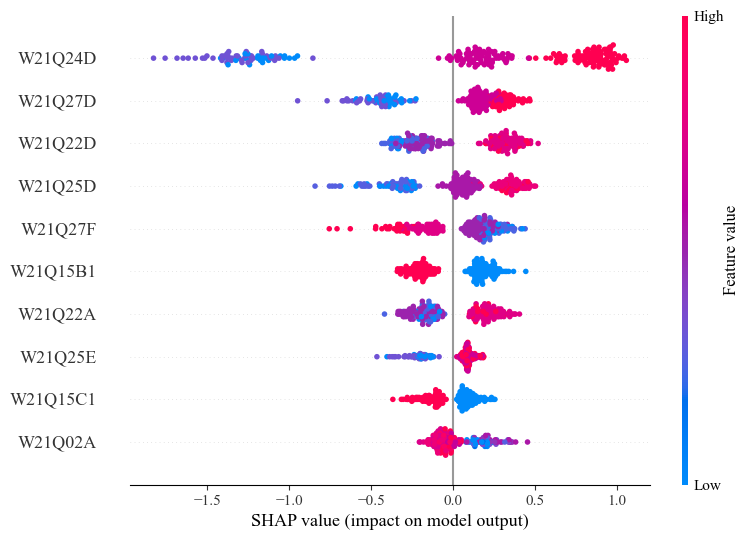


 W21Q261 

2    4658
1     787
Name: W21Q261, dtype: int64
1    787
2    787
Name: W21Q261, dtype: int64
	Accuracy ========>  0.8952380952380953
Index(['W21Q24A', 'W21Q27D', 'W21Q24B', 'W21Q23A', 'W21Q14F', 'W21Q302',
       'W21Q24D', 'W21Q27E', 'W21Q27A', 'W21Q27F'],
      dtype='object')


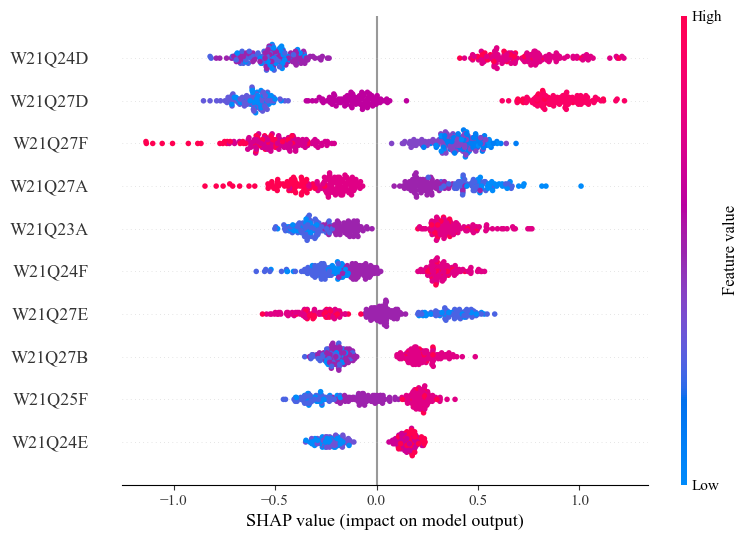

In [40]:
import shap

Y = ['W21Q26A', 'W21Q26B', 'W21Q26C', 'W21Q261']

perum_imp = []
for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, x_tst, y_tst = XGBoost(X, y)
    
    PI = permutational_importance_(model, x_tst, y_tst, X)
    
    explainer = shap.TreeExplainer(model) 
    shap_values = explainer.shap_values(x_tst)

    shap.summary_plot(shap_values, x_tst, max_display=10, plot_type='dot')  #violin, dot, bar, compact_dot, layered_violin
    perum_imp.append(PI)

In [43]:
FI = [['W21Q27F', 'W21Q27D', 'W21Q24F', 'W21Q24D', 'W21Q22C', 'W21Q27A', 'W21Q24E', 'W21Q23B', 'W21Q25D', 'W21Q25G'], 
     ['W21Q24E', 'W21Q27A', 'W21Q27D', 'W21Q27C', 'W21Q23A', 'W21Q27F', 'W21Q27E', 'W21QID1', 'W21QDQ01', 'W21Q25B'], 
     ['W21Q24D', 'W21Q27D', 'W21Q22D', 'W21Q25D', 'W21Q27F', 'W21Q15B1', 'W21Q22A', 'W21Q25E', 'W21Q15C1', 'W21Q02A'], 
     ['W21Q24D', 'W21Q27D', 'W21Q27F', 'W21Q27A', 'W21Q23A', 'W21Q24F', 'W21Q27E', 'W21Q27B', 'W21Q25F', 'W21Q24E']]

m2 = ['W21Q27F', 'W21Q09D', 'W21Q22D', 'W21DQ02A', 'W21ID1', 'W21Q27B',
       'W21Q27D', 'W21Q24D', 'W21Q25E', 'W21Q22F', 'W21Q27D', 'W21Q24F',
       'W21Q24D', 'W21Q25D', 'W21Q27F', 'W21Q24E', 'W21Q27A', 'W21Q23A',
       'W21Q22D', 'W21Q25B']

In [44]:
from collections import Counter

arr_1d = np.array(np.array(FI+perum_imp)).flatten()
arr_1d = arr_1d.tolist() + m2

element_counts = Counter(arr_1d)

top_5_elements = element_counts.most_common(5)

print("Top 5 elements with highest frequency:")
for element, frequency in top_5_elements:
    print("Element:", element, "Frequency:", frequency)

Top 5 elements with highest frequency:
Element: W21Q27D Frequency: 9
Element: W21Q27F Frequency: 8
Element: W21Q24D Frequency: 7
Element: W21Q27A Frequency: 7
Element: W21Q24E Frequency: 5


# 7. 조직몰입 

(1) 나는 조금이라도 좋은 조건을 제시하는 회사가 있으면 옮길 것을 고려해 보고 있다

(2) 나는 이 회사의 문제를 내 문제처럼 느낀다

(3) 만약 내가 이 회사를 떠나기로 결정한다면 내 인생의 너무 많은 것을 잃게 될 것이다

(4) 이 회사는 내가 충성할 만한 가치가 있다

In [ ]:
Y = ['W21Q27A', 'W21Q27B', 'W21Q27C', 'W21Q27D']

for i in range(1):  
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    X, y = equal_distirubution(X, Y, i)
    y=y-1
    model, x_tr, _, _ = XGBoost_learning_curve(X, y, 'Organizational Commitment (W21Q27A)')

In [ ]:
Y = ['W21Q27A', 'W21Q27B', 'W21Q27C', 'W21Q27D']

for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, _, _ = XGBoost(X, y)
    model, x_tr, _, _ = LightGBM(X, y)
    model, x_tr, _, _ = CatBoost(X, y)
    model, x_tr, _, _ = RF(X, y)
    #RF_grid_search(X, y)
    #Catboost_grid_search(X, y)
    #model, x_tr, _, _ = XGBoost(X, y, num_boost_round = 300)
    #feature_imp1(model, x_tr, top_k=10)


 W21Q27A 

2    3684
1    2354
Name: W21Q27A, dtype: int64
2    2354
1    2354
Name: W21Q27A, dtype: int64
	Accuracy ========>  0.8248407643312102
Index(['W21Q261', 'W21Q062A', 'W21Q083E', 'W21DQ01', 'W21Q25G', 'W21Q25I',
       'W21DQ02A', 'W21Q26B', 'W21Q27F', 'W21Q27E'],
      dtype='object')


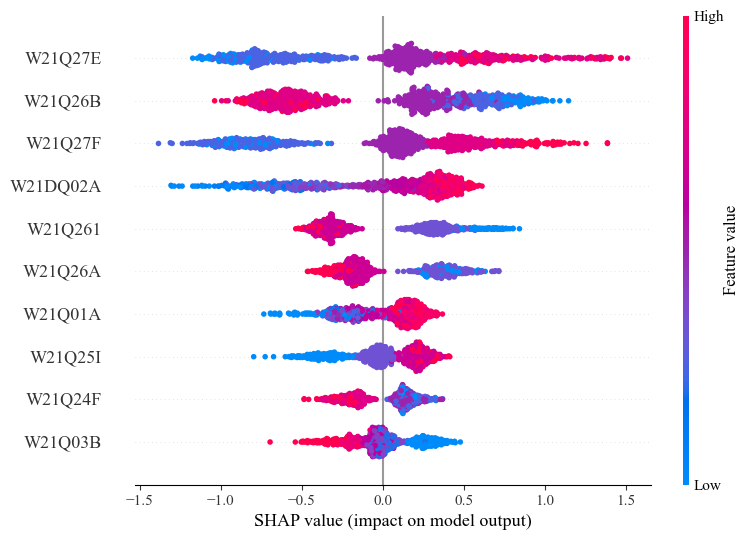


 W21Q27B 

2    4765
1    1227
Name: W21Q27B, dtype: int64
1    1227
2    1227
Name: W21Q27B, dtype: int64
	Accuracy ========>  0.7780040733197556
Index(['W21Q26C', 'W21Q09E', 'W21Q22D', 'W21Q261', 'W21Q22B', 'W21DQ02A',
       'W21Q25F', 'W21Q27G', 'W21Q26A', 'W21Q24A'],
      dtype='object')


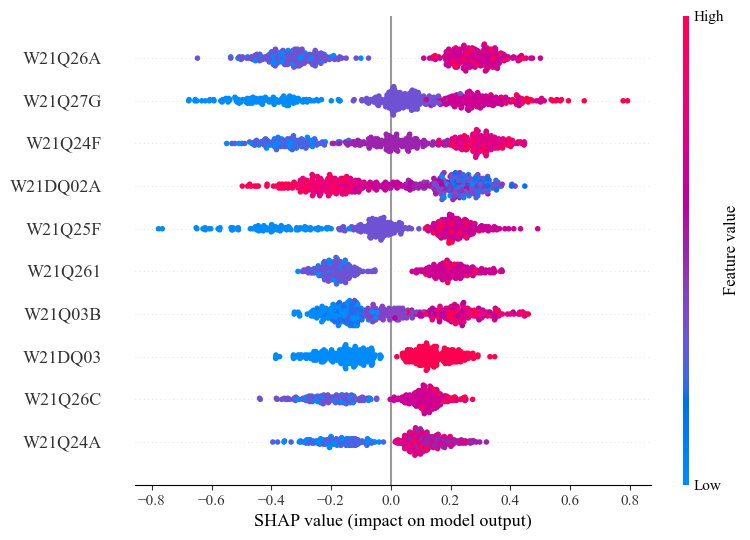


 W21Q27C 

1    3409
2    2419
Name: W21Q27C, dtype: int64
2    2419
1    2419
Name: W21Q27C, dtype: int64
	Accuracy ========>  0.8502066115702479
Index(['W21Q05A', 'W21Q26A', 'W21Q27F', 'W21Q25D', 'W21Q27E', 'W21DQ01',
       'W21Q23C', 'W21Q26B', 'W21Q27G', 'W21Q01A'],
      dtype='object')


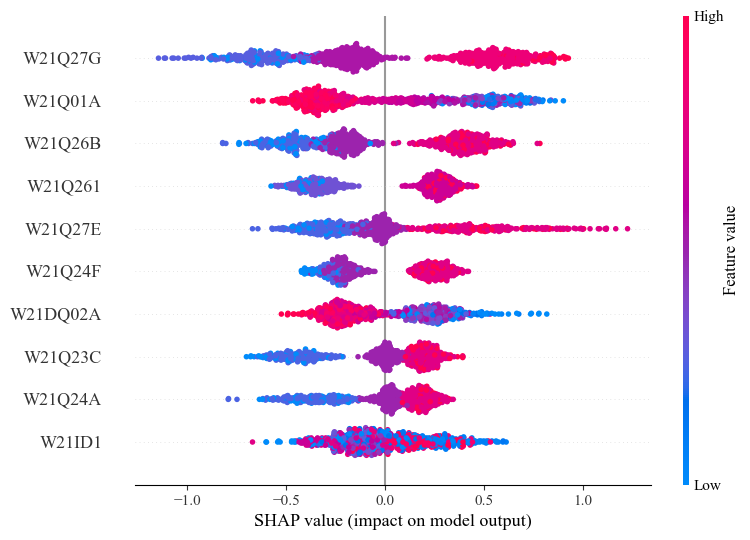


 W21Q27D 

2    3509
1    1669
Name: W21Q27D, dtype: int64
1    1669
2    1669
Name: W21Q27D, dtype: int64
	Accuracy ========>  0.9026946107784432
Index(['W21Q01B', 'W21Q02B', 'W21Q03B', 'W21Q25B', 'W21Q23B', 'W21Q25D',
       'W21Q26B', 'W21Q27G', 'W21Q261', 'W21Q24F'],
      dtype='object')


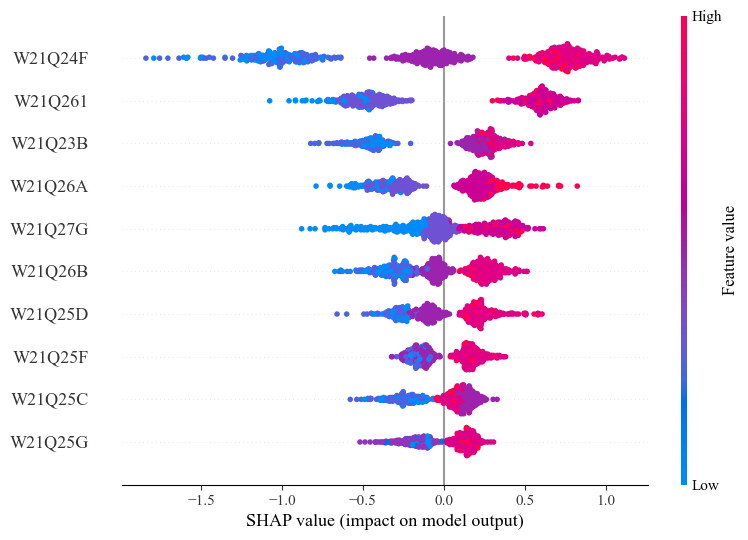

In [45]:
import shap

Y = ['W21Q27A', 'W21Q27B', 'W21Q27C', 'W21Q27D']

perum_imp = []
for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, x_tst, y_tst = XGBoost(X, y)
    
    PI = permutational_importance_(model, x_tst, y_tst, X)
    
    explainer = shap.TreeExplainer(model) 
    shap_values = explainer.shap_values(x_tst)

    shap.summary_plot(shap_values, x_tst, max_display=10, plot_type='dot')  #violin, dot, bar, compact_dot, layered_violin
    perum_imp.append(PI)

In [46]:
FI = [['W21Q27E', 'W21Q26B', 'W21Q27F', 'W21DQ02A', 'W21Q261', 'W21Q26A', 'W21Q01A', 'W21Q25I', 'W21Q24F', 'W21Q03B'],
      ['W21Q26A', 'W21Q27G', 'W21Q24F', 'W21DQ02A', 'W21Q25F', 'W21Q261', 'W21Q03B', 'W21DQ03', 'W21Q26C', 'W21Q24A'],
      ['W21Q27G', 'W21Q01A', 'W21Q26B', 'W21Q261', 'W21Q27E', 'W21Q24F', 'W21DQ02A', 'W21Q23C', 'W21Q24A', 'W21ID1'],
      ['W21Q24F', 'W21Q261', 'W21Q23B', 'W21Q26A', 'W21Q27G', 'W21Q26B', 'W21Q25D', 'W21Q25F', 'W21Q25C', 'W21Q25G'],
     ]
m2 = ['W21Q081C', 'W21Q12C', 'W21Q02A', 'W21Q07', 'W21Q27G', 'W21DQ03',
       'W21Q261', 'W21DQ02A', 'W21Q27F', 'W21Q27E', 'W21Q261', 'W21Q24F',
       'W21Q26A', 'W21Q27E', 'W21DQ02A', 'W21Q26B', 'W21Q27G', 'W21Q01A','W21Q27F', 'W21Q24A']


from collections import Counter

arr_1d = np.array(np.array(FI+perum_imp)).flatten()
arr_1d = arr_1d.tolist() + m2

element_counts = Counter(arr_1d)

top_5_elements = element_counts.most_common(5)

print("Top 5 elements with highest frequency:")
for element, frequency in top_5_elements:
    print("Element:", element, "Frequency:", frequency)

Top 5 elements with highest frequency:
Element: W21Q261 Frequency: 9
Element: W21Q27G Frequency: 8
Element: W21Q26B Frequency: 7
Element: W21DQ02A Frequency: 7
Element: W21Q27E Frequency: 6


# 8. 번아웃 

(6) 나는 현재 업무로 인해 무력감이나 피곤함을 느낄 때가 많아졌다


 W21Q27F 

2    3159
1    2329
Name: W21Q27F, dtype: int64
2    2329
1    2329
Name: W21Q27F, dtype: int64
	Accuracy ========>  0.8594420600858369
Index(['W21Q18A', 'W21Q082E', 'W21DQ02A', 'W21Q261', 'W21Q21', 'W21Q083D',
       'W21Q27C', 'W21Q26A', 'W21Q27E', 'W21Q27G'],
      dtype='object')


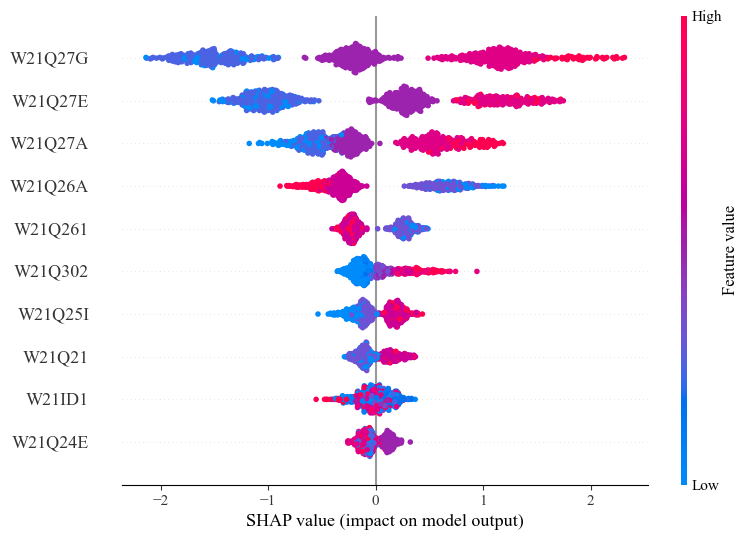

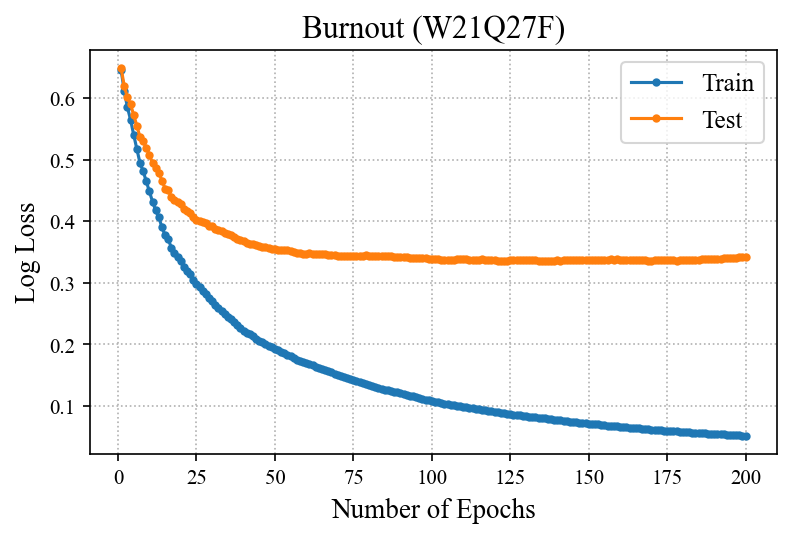

In [56]:
Y = ['W21Q27F']

perum_imp = []
for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, x_tst, y_tst = XGBoost(X, y)
    
    PI = permutational_importance_(model, x_tst, y_tst, X)
    
    explainer = shap.TreeExplainer(model) 
    shap_values = explainer.shap_values(x_tst)

    shap.summary_plot(shap_values, x_tst, max_display=10, plot_type='dot')  #violin, dot, bar, compact_dot, layered_violin
    perum_imp.append(PI)
    model, x_tr, _, _ = XGBoost_learning_curve(X, y, 'Burnout (W21Q27F)')

In [58]:
FI = ['W21Q27G', 'W21Q27E', 'W21Q26A', 'W21Q27A', 'W21Q261', 'W21Q25I', 'W21Q302', 'W21Q01A', 'W21Q21', 'W21QID1']

from collections import Counter

arr_1d = np.array(np.array(FI+perum_imp[0])).flatten()

element_counts = Counter(arr_1d)

top_5_elements = element_counts.most_common(5)

print("Top 5 elements with highest frequency:")
for element, frequency in top_5_elements:
    print("Element:", element, "Frequency:", frequency)

Top 5 elements with highest frequency:
Element: W21Q27GW21Q18A Frequency: 1
Element: W21Q27EW21Q082E Frequency: 1
Element: W21Q26AW21DQ02A Frequency: 1
Element: W21Q27AW21Q261 Frequency: 1
Element: W21Q261W21Q21 Frequency: 1


In [ ]:
Y = ['W21Q27F']

for i in range(len(Y)):  
    print("\n==================================================\n", Y[i], "\n==================================================\n")
    X = class_one_to_five_TO_one_to_two(df, Y, i)
    
    X, y = equal_distirubution(X, Y, i)
    
    y=y-1
    model, x_tr, _, _ = XGBoost(X, y)
    model, x_tr, _, _ = LightGBM(X, y)
    model, x_tr, _, _ = CatBoost(X, y)
    model, x_tr, _, _ = RF(X, y)
    #RF_grid_search(X, y)
    #Catboost_grid_search(X,y)
    #model, x_tr, x_tst, y_tst = XGBoost(X, y, num_boost_round = 300)
    feature_imp1(model, x_tr, top_k=15)

# Feature importance랑 Permutation importance는 유사함 (sorting)

# SMOTE -> data augmentation based on synthetic dataset

justification: 심하게 skewed 된 학습데이터만 증강 기법을 써서 올림 => test 데이터 자체는 그대로 유지

Overfitting 이 보이는 시점이 있음 => 실제로 어느정도는 도움이 된다는 뜻

In [ ]:
from xgboost import XGBClassifier, plot_importance
scaler = MinMaxScaler()
from imblearn.over_sampling import SMOTE

X = df_no_nan.drop(columns=[Y[target_idx]])
y = df_no_nan[Y[target_idx]] 
X_normalized = scaler.fit_transform(X)
df = pd.DataFrame(X_normalized, columns=X.columns)

print(y.value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)

print(y_resampled.value_counts())

In [ ]:
y_resampled = y_resampled - 1

X_train, X_test, y_train, y_test = train_test_split(balanced_df, y_resampled, test_size=0.2, random_state=42)

num_boost_round = 300  
model = XGBClassifier(n_estimators=num_boost_round)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=True)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)